In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import numpy as np

In [2]:
class Matryoshka_CE_Loss(nn.Module):
    def __init__(self, relative_importance=None, **kwargs):
        super(Matryoshka_CE_Loss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(**kwargs)
        self.relative_importance = relative_importance

    def forward(self, output, target):
        losses = torch.stack([self.criterion(output_i, target) for output_i in output])
        rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.as_tensor(self.relative_importance, device=losses.device).clone().detach()        
        weighted_losses = rel_importance * losses
        return weighted_losses.sum()

class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list, num_classes=100, efficient=False, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes
        self.efficient = efficient
        if self.efficient:
            self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, **kwargs)
        else:
            for i, num_feat in enumerate(self.nesting_list):
                setattr(self, f"nesting_classifier_{i}", nn.Linear(num_feat, self.num_classes, **kwargs))

    def forward(self, x):
        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            if self.efficient:
                if self.nesting_classifier_0.bias is None:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()), )
                else:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()) + self.nesting_classifier_0.bias, )
            else:
                nesting_logits += (getattr(self, f"nesting_classifier_{i}")(x[:, :num_feat]),)
        return nesting_logits

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=1)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
nesting_list = [8, 16, 32, 64, 128, 256, 512]
model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = MRL_Linear_Layer(nesting_list, num_classes=100, efficient=False)
model = model.to(device)

In [6]:
def train(epoch):
    model.train()
    train_loss = 0
    correct = {n: 0 for n in nesting_list}
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        for i, n in enumerate(nesting_list):
            _, predicted = outputs[i].max(1)
            correct[n] += predicted.eq(targets).sum().item()
        total += targets.size(0)

    avg_acc = 100. * sum(correct.values()) / (total * len(nesting_list))
    print(f'Epoch: {epoch} | Loss: {train_loss/(batch_idx+1):.3f} | Avg Acc: {avg_acc:.3f}%')

In [7]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct_top1 = {n: 0 for n in nesting_list}
    correct_top5 = {n: 0 for n in nesting_list}
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            for i, n in enumerate(nesting_list):
                _, predicted = outputs[i].max(1)
                correct_top1[n] += predicted.eq(targets).sum().item()
                
                _, top5_pred = outputs[i].topk(5, 1, True, True)
                correct_top5[n] += top5_pred.eq(targets.view(-1, 1)).sum().item()
            
            total += targets.size(0)

    avg_top1 = sum(100. * correct_top1[n] / total for n in nesting_list) / len(nesting_list)
    avg_top5 = sum(100. * correct_top5[n] / total for n in nesting_list) / len(nesting_list)
    
    print("\n┌──────────┬────────────┬────────────┐")
    print(f"│ {'Size':^8} │ {'Top-1 Acc':^10} │ {'Top-5 Acc':^10} │")
    print("├──────────┼────────────┼────────────┤")
    
    for n in nesting_list:
        top1 = 100. * correct_top1[n] / total
        top5 = 100. * correct_top5[n] / total
        print(f"│ {n:^8} │ {top1:>9.2f}% │ {top5:>9.2f}% │")
    
    print("├──────────┼────────────┼────────────┤")
    print(f"│ {'Average':^8} │ {avg_top1:>9.2f}% │ {avg_top5:>9.2f}% │")
    print("└──────────┴────────────┴────────────┘")
    
    return avg_top1 

In [8]:
relative_importance = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
relative_importance_tensor = torch.tensor(relative_importance, device=device)
criterion = Matryoshka_CE_Loss(relative_importance=relative_importance_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

Epoch: 0 | Loss: 28.455 | Avg Acc: 6.624%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │      9.43% │     30.69% │
│    16    │     10.80% │     33.80% │
│    32    │     12.42% │     35.72% │
│    64    │     13.27% │     36.15% │
│   128    │     13.09% │     36.60% │
│   256    │     13.40% │     37.27% │
│   512    │     13.46% │     36.98% │
├──────────┼────────────┼────────────┤
│ Average  │     12.27% │     35.32% │
└──────────┴────────────┴────────────┘
Epoch: 1 | Loss: 24.435 | Avg Acc: 15.631%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     14.28% │     41.00% │
│    16    │     17.18% │     45.79% │
│    32    │     19.14% │     48.41% │
│    64    │     19.84% │     49.26% │
│   128    │     20.06% │     49.66% │
│   256    │     20.23% │     50.03% │
│   512    │     20.29% │     50.04% │
├──────────┼────

Epoch: 15 | Loss: 13.500 | Avg Acc: 47.813%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     37.26% │     69.05% │
│    16    │     41.26% │     73.15% │
│    32    │     42.49% │     74.84% │
│    64    │     43.76% │     75.53% │
│   128    │     44.53% │     76.00% │
│   256    │     44.60% │     76.23% │
│   512    │     44.61% │     76.06% │
├──────────┼────────────┼────────────┤
│ Average  │     42.64% │     74.41% │
└──────────┴────────────┴────────────┘
Epoch: 16 | Loss: 13.248 | Avg Acc: 48.934%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     35.11% │     66.95% │
│    16    │     41.24% │     72.43% │
│    32    │     41.90% │     73.70% │
│    64    │     42.94% │     74.34% │
│   128    │     43.60% │     74.94% │
│   256    │     43.60% │     74.78% │
│   512    │     43.70% │     74.88% │
├──────────┼─

Epoch: 30 | Loss: 11.777 | Avg Acc: 54.190%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     44.93% │     73.56% │
│    16    │     48.68% │     77.67% │
│    32    │     49.15% │     79.13% │
│    64    │     49.73% │     79.80% │
│   128    │     50.25% │     80.10% │
│   256    │     50.35% │     80.15% │
│   512    │     50.02% │     80.11% │
├──────────┼────────────┼────────────┤
│ Average  │     49.02% │     78.65% │
└──────────┴────────────┴────────────┘
Epoch: 31 | Loss: 11.703 | Avg Acc: 54.465%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     42.72% │     70.85% │
│    16    │     47.96% │     76.48% │
│    32    │     49.49% │     78.04% │
│    64    │     49.85% │     79.02% │
│   128    │     49.80% │     79.25% │
│   256    │     49.99% │     79.61% │
│   512    │     49.52% │     79.38% │
├──────────┼─

Epoch: 45 | Loss: 10.931 | Avg Acc: 57.388%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     44.10% │     71.40% │
│    16    │     49.14% │     76.31% │
│    32    │     50.61% │     77.54% │
│    64    │     50.75% │     78.22% │
│   128    │     50.89% │     78.81% │
│   256    │     51.48% │     79.16% │
│   512    │     51.45% │     79.22% │
├──────────┼────────────┼────────────┤
│ Average  │     49.77% │     77.24% │
└──────────┴────────────┴────────────┘
Epoch: 46 | Loss: 10.894 | Avg Acc: 57.407%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     44.17% │     71.72% │
│    16    │     48.30% │     75.95% │
│    32    │     49.27% │     77.53% │
│    64    │     49.27% │     78.23% │
│   128    │     48.94% │     78.46% │
│   256    │     49.26% │     78.71% │
│   512    │     48.94% │     78.80% │
├──────────┼─

Epoch: 60 | Loss: 10.187 | Avg Acc: 60.175%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     48.58% │     75.42% │
│    16    │     52.62% │     79.46% │
│    32    │     53.74% │     80.70% │
│    64    │     54.28% │     81.77% │
│   128    │     54.48% │     81.89% │
│   256    │     54.48% │     82.24% │
│   512    │     54.31% │     82.15% │
├──────────┼────────────┼────────────┤
│ Average  │     53.21% │     80.52% │
└──────────┴────────────┴────────────┘
Epoch: 61 | Loss: 10.135 | Avg Acc: 60.369%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     48.82% │     74.65% │
│    16    │     51.20% │     77.82% │
│    32    │     52.04% │     79.19% │
│    64    │     52.54% │     79.95% │
│   128    │     52.52% │     80.32% │
│   256    │     52.54% │     80.46% │
│   512    │     52.37% │     80.55% │
├──────────┼─

Epoch: 75 | Loss: 9.394 | Avg Acc: 62.852%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     52.24% │     78.34% │
│    16    │     55.03% │     81.29% │
│    32    │     55.57% │     83.08% │
│    64    │     56.06% │     83.65% │
│   128    │     56.31% │     83.91% │
│   256    │     56.30% │     84.20% │
│   512    │     56.02% │     84.17% │
├──────────┼────────────┼────────────┤
│ Average  │     55.36% │     82.66% │
└──────────┴────────────┴────────────┘
Epoch: 76 | Loss: 9.279 | Avg Acc: 63.272%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     51.28% │     77.23% │
│    16    │     54.74% │     80.09% │
│    32    │     55.30% │     81.72% │
│    64    │     55.27% │     82.44% │
│   128    │     55.83% │     83.15% │
│   256    │     55.99% │     83.32% │
│   512    │     56.10% │     83.45% │
├──────────┼───

Epoch: 90 | Loss: 8.361 | Avg Acc: 66.791%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     49.00% │     74.94% │
│    16    │     52.55% │     78.39% │
│    32    │     53.05% │     79.79% │
│    64    │     53.78% │     80.74% │
│   128    │     53.84% │     81.09% │
│   256    │     53.81% │     81.36% │
│   512    │     53.62% │     81.23% │
├──────────┼────────────┼────────────┤
│ Average  │     52.81% │     79.65% │
└──────────┴────────────┴────────────┘
Epoch: 91 | Loss: 8.353 | Avg Acc: 66.908%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     52.95% │     78.75% │
│    16    │     55.38% │     81.53% │
│    32    │     56.42% │     83.03% │
│    64    │     56.62% │     83.58% │
│   128    │     57.35% │     84.25% │
│   256    │     57.37% │     84.29% │
│   512    │     57.29% │     84.51% │
├──────────┼───

Epoch: 105 | Loss: 7.261 | Avg Acc: 70.705%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     54.98% │     79.67% │
│    16    │     57.89% │     82.94% │
│    32    │     58.80% │     83.95% │
│    64    │     59.01% │     84.44% │
│   128    │     59.06% │     84.64% │
│   256    │     59.37% │     84.91% │
│   512    │     59.36% │     85.13% │
├──────────┼────────────┼────────────┤
│ Average  │     58.35% │     83.67% │
└──────────┴────────────┴────────────┘
Epoch: 106 | Loss: 7.143 | Avg Acc: 71.092%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     57.57% │     81.41% │
│    16    │     60.36% │     84.48% │
│    32    │     61.30% │     85.69% │
│    64    │     61.30% │     86.17% │
│   128    │     61.65% │     86.64% │
│   256    │     61.91% │     86.96% │
│   512    │     62.09% │     87.05% │
├──────────┼─

Epoch: 120 | Loss: 5.909 | Avg Acc: 75.629%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     54.58% │     78.61% │
│    16    │     57.83% │     81.83% │
│    32    │     58.56% │     83.50% │
│    64    │     58.90% │     84.28% │
│   128    │     58.91% │     84.65% │
│   256    │     59.04% │     84.83% │
│   512    │     59.07% │     84.99% │
├──────────┼────────────┼────────────┤
│ Average  │     58.13% │     83.24% │
└──────────┴────────────┴────────────┘
Epoch: 121 | Loss: 5.732 | Avg Acc: 76.498%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     58.55% │     80.85% │
│    16    │     60.88% │     84.14% │
│    32    │     61.36% │     85.45% │
│    64    │     61.84% │     85.98% │
│   128    │     61.81% │     86.02% │
│   256    │     61.88% │     86.29% │
│   512    │     61.97% │     86.40% │
├──────────┼─

Epoch: 135 | Loss: 4.107 | Avg Acc: 82.727%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     59.16% │     81.04% │
│    16    │     62.19% │     83.71% │
│    32    │     62.74% │     85.68% │
│    64    │     62.75% │     86.14% │
│   128    │     62.99% │     86.36% │
│   256    │     62.77% │     86.54% │
│   512    │     62.77% │     86.66% │
├──────────┼────────────┼────────────┤
│ Average  │     62.20% │     85.16% │
└──────────┴────────────┴────────────┘
Epoch: 136 | Loss: 4.088 | Avg Acc: 82.888%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     59.37% │     80.42% │
│    16    │     61.97% │     83.74% │
│    32    │     62.68% │     85.35% │
│    64    │     62.78% │     85.90% │
│   128    │     62.83% │     86.01% │
│   256    │     62.89% │     86.19% │
│   512    │     62.86% │     86.41% │
├──────────┼─

Epoch: 150 | Loss: 2.140 | Avg Acc: 90.785%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     61.41% │     81.24% │
│    16    │     63.34% │     84.90% │
│    32    │     64.12% │     86.40% │
│    64    │     64.20% │     86.90% │
│   128    │     64.48% │     87.06% │
│   256    │     64.49% │     87.16% │
│   512    │     64.49% │     87.35% │
├──────────┼────────────┼────────────┤
│ Average  │     63.79% │     85.86% │
└──────────┴────────────┴────────────┘
Epoch: 151 | Loss: 2.077 | Avg Acc: 91.109%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     61.65% │     81.88% │
│    16    │     63.72% │     85.09% │
│    32    │     64.35% │     86.59% │
│    64    │     64.25% │     86.98% │
│   128    │     64.36% │     87.13% │
│   256    │     64.33% │     87.33% │
│   512    │     64.48% │     87.48% │
├──────────┼─

Epoch: 165 | Loss: 0.573 | Avg Acc: 97.697%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     65.29% │     83.07% │
│    16    │     67.22% │     86.22% │
│    32    │     67.73% │     87.79% │
│    64    │     67.96% │     88.08% │
│   128    │     68.12% │     88.21% │
│   256    │     68.09% │     88.32% │
│   512    │     68.15% │     88.40% │
├──────────┼────────────┼────────────┤
│ Average  │     67.51% │     87.16% │
└──────────┴────────────┴────────────┘
Epoch: 166 | Loss: 0.580 | Avg Acc: 97.633%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     64.57% │     83.15% │
│    16    │     67.13% │     86.51% │
│    32    │     67.77% │     87.39% │
│    64    │     67.99% │     87.87% │
│   128    │     67.90% │     88.13% │
│   256    │     67.97% │     88.22% │
│   512    │     68.02% │     88.24% │
├──────────┼─

Epoch: 180 | Loss: 0.114 | Avg Acc: 99.695%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     67.10% │     84.13% │
│    16    │     69.41% │     86.92% │
│    32    │     69.87% │     88.40% │
│    64    │     70.03% │     89.00% │
│   128    │     70.15% │     89.15% │
│   256    │     70.18% │     89.26% │
│   512    │     70.12% │     89.24% │
├──────────┼────────────┼────────────┤
│ Average  │     69.55% │     88.01% │
└──────────┴────────────┴────────────┘
Epoch: 181 | Loss: 0.106 | Avg Acc: 99.735%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     67.39% │     84.28% │
│    16    │     69.44% │     87.30% │
│    32    │     70.08% │     88.56% │
│    64    │     70.31% │     89.06% │
│   128    │     70.35% │     89.17% │
│   256    │     70.43% │     89.28% │
│   512    │     70.41% │     89.30% │
├──────────┼─

Epoch: 195 | Loss: 0.070 | Avg Acc: 99.865%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     67.43% │     84.29% │
│    16    │     70.04% │     87.46% │
│    32    │     70.15% │     88.77% │
│    64    │     70.37% │     89.36% │
│   128    │     70.56% │     89.45% │
│   256    │     70.52% │     89.49% │
│   512    │     70.58% │     89.53% │
├──────────┼────────────┼────────────┤
│ Average  │     69.95% │     88.34% │
└──────────┴────────────┴────────────┘
Epoch: 196 | Loss: 0.074 | Avg Acc: 99.853%

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    8     │     67.57% │     84.28% │
│    16    │     69.92% │     87.30% │
│    32    │     70.16% │     88.68% │
│    64    │     70.40% │     89.33% │
│   128    │     70.52% │     89.40% │
│   256    │     70.57% │     89.44% │
│   512    │     70.55% │     89.50% │
├──────────┼─

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


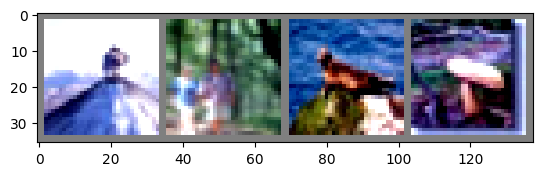

GroundTruth:	 49	33	72	51
Size		Image 1	Image 2	Image 3	Image 4
8		33	33	55	51
16		68	33	55	51
32		68	33	55	51
64		68	33	55	51
128		68	33	55	51
256		68	33	55	51
512		68	33	55	51


In [9]:
best_acc = 0
for epoch in range(200):
    train(epoch)
    acc = test(epoch)
    scheduler.step()

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model_mrl.pth')

print(f'Best Test Accuracy: {best_acc:.2f}%')

import matplotlib.pyplot as plt
def imshow(img):
    img = img * torch.tensor([0.2675, 0.2565, 0.2761]).view(3, 1, 1) + \
          torch.tensor([0.5071, 0.4867, 0.4408]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:\t', '\t'.join(f'{labels[j]}' for j in range(4)))

print("Size\t\t" + "\t".join(f"Image {j+1}" for j in range(4)))
outputs = model(images[:4].to(device))
for i, n in enumerate(nesting_list):
    _, predicted = torch.max(outputs[i], 1)
    print(f"{n}\t\t" + "\t".join(f"{predicted[j].item()}" for j in range(4)))